In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

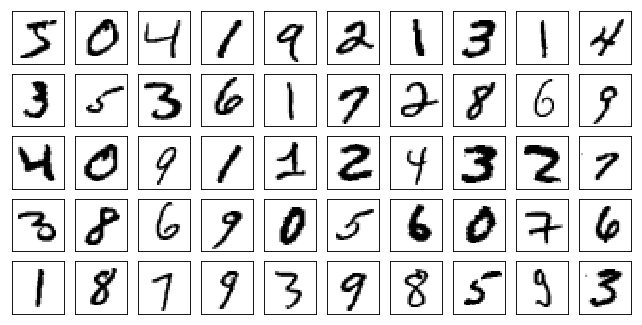

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):           
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.327237 drop: 2.327067 plain: 2.398716
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.940708 drop: 2.064648 plain: 2.166881
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.701396 drop: 1.560394 plain: 1.792192
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.356526 drop: 1.018548 plain: 1.202888
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.990829 drop: 0.651022 plain: 0.738635
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.963648 drop: 0.721057 plain: 0.716659
Test set:
bn: Loss: 0.9073	Accuracy: 8850.0/10000 (88%)
drop: Loss: 0.6407	Accuracy: 8445.0/10000 (84%)
plain: Loss: 0.6657	Accuracy: 8510.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.997129 drop: 0.727063 plain: 0.745833
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.682070 drop: 0.406315 plain: 0.428687
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.486867 drop: 0.359889 plain: 0.347797
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.545352 drop: 0.371274 plain: 0.34

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.097599 drop: 0.141717 plain: 0.099757
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.087630 drop: 0.099346 plain: 0.125132
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.072654 drop: 0.091802 plain: 0.093036
Test set:
bn: Loss: 0.0702	Accuracy: 9790.0/10000 (98%)
drop: Loss: 0.0874	Accuracy: 9761.0/10000 (98%)
plain: Loss: 0.0818	Accuracy: 9784.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.029795 drop: 0.061071 plain: 0.057620
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.078697 drop: 0.104760 plain: 0.097463
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.039354 drop: 0.049134 plain: 0.053806
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.115576 drop: 0.137587 plain: 0.077492
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.049868 drop: 0.040388 plain: 0.031665
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.050742 drop: 0.038363 plain: 0.041651
Test set:
bn: Loss: 0.0659	Accuracy: 9822.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.062874 drop: 0.063268 plain: 0.067614
Test set:
bn: Loss: 0.0466	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0584	Accuracy: 9846.0/10000 (98%)
plain: Loss: 0.0562	Accuracy: 9838.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.026951 drop: 0.027114 plain: 0.026477
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.022352 drop: 0.034438 plain: 0.032168
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.020409 drop: 0.032141 plain: 0.032243
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.005217 drop: 0.033979 plain: 0.023460
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.025118 drop: 0.013730 plain: 0.014087
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.044910 drop: 0.037579 plain: 0.045741
Test set:
bn: Loss: 0.0484	Accuracy: 9867.0/10000 (99%)
drop: Loss: 0.0591	Accuracy: 9844.0/10000 (98%)
plain: Loss: 0.0568	Accuracy: 9841.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.018049 drop: 0.011464 plain: 0.011011
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.005484 drop: 0.023479 plain: 0.014725
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.021665 drop: 0.028262 plain: 0.029909
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.003145 drop: 0.008260 plain: 0.005832
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.017277 drop: 0.018855 plain: 0.023037
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.071951 drop: 0.054389 plain: 0.047094
Test set:
bn: Loss: 0.0425	Accuracy: 9877.0/10000 (99%)
drop: Loss: 0.0506	Accuracy: 9862.0/10000 (99%)
plain: Loss: 0.0484	Accuracy: 9858.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.003092 drop: 0.005656 plain: 0.006828
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.009749 drop: 0.012060 plain: 0.008190
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.024282 drop: 0.028808 plain: 0.028665
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.031108 drop: 0.047713 plain: 0.055226
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.002226 drop: 0.009

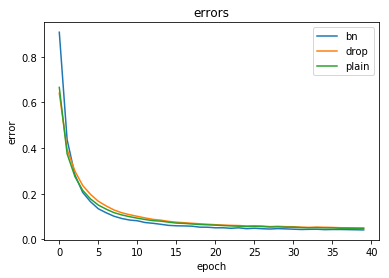

In [11]:
plot_graphs(test_log, 'loss')

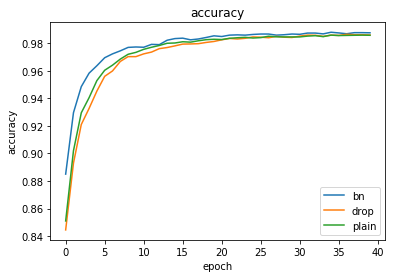

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
torch.save(models['bn'], './model_classifier_convs')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [8]:
model = torch.load('./model_classifier_convs')

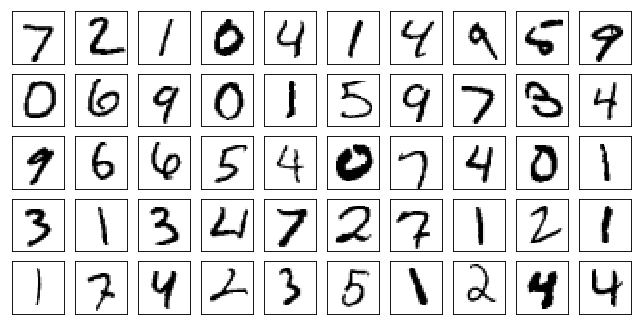

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [9]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

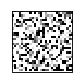

In [21]:
data, _ = next(iter(test_loader))
#img = data[2].view(-1, 1, 28, 28)
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [22]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.ones((1), dtype=torch.long) * cl
    steps_since_lr_decreased = 0
    #target[cl] = 1
    #target = target.view(1, 10)
    
    loss_stats = []    
    lr = 1e-1
    
    for i in range(1, 10000001):  
             
        out = model.forward(gen_img_par)        
             
        gen_optim = optim.RMSprop([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={} prediction={} lr={}".format(i,loss, out.argmax(), lr))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                       
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
       
   
                        
    return gen_img_par, loss_stats    

Iteration 5000: loss=9.110578957916005e-11 prediction=4 lr=0.1
Iteration 10000: loss=3.565148176676303e-11 prediction=4 lr=0.1
Iteration 15000: loss=2.8478552849264815e-11 prediction=4 lr=0.1
Iteration 20000: loss=2.5405455517102382e-11 prediction=4 lr=0.1
Iteration 25000: loss=2.3355539724434493e-11 prediction=4 lr=0.1
Iteration 30000: loss=2.184208369726548e-11 prediction=4 lr=0.1
Iteration 35000: loss=2.0673240896940115e-11 prediction=4 lr=0.1
Iteration 40000: loss=1.9742429913094384e-11 prediction=4 lr=0.1
Iteration 45000: loss=1.8971491044794675e-11 prediction=4 lr=0.1
Iteration 50000: loss=1.829292273214378e-11 prediction=4 lr=0.1


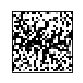

Iteration 55000: loss=1.7678303265711293e-11 prediction=4 lr=0.1
Iteration 60000: loss=1.709565822238801e-11 prediction=4 lr=0.1
Iteration 65000: loss=1.652367132010113e-11 prediction=4 lr=0.1
Iteration 70000: loss=1.596234255885065e-11 prediction=4 lr=0.1
Iteration 75000: loss=1.538680294288497e-11 prediction=4 lr=0.1
Iteration 80000: loss=1.4782841617488884e-11 prediction=4 lr=0.1
Iteration 85000: loss=1.4157564010019996e-11 prediction=4 lr=0.1
Iteration 90000: loss=1.3557155398302712e-11 prediction=4 lr=0.1
Iteration 95000: loss=1.2992273923373432e-11 prediction=4 lr=0.1
Iteration 100000: loss=1.247713043994736e-11 prediction=4 lr=0.1


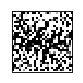

Iteration 105000: loss=1.2025935802739696e-11 prediction=4 lr=0.1
Iteration 110000: loss=1.1617373729677638e-11 prediction=4 lr=0.1
Iteration 115000: loss=1.1233680652367184e-11 prediction=4 lr=0.1
Iteration 120000: loss=1.0867751143450732e-11 prediction=4 lr=0.1
Iteration 125000: loss=1.0533796057643485e-11 prediction=4 lr=0.1
Iteration 130000: loss=1.0238920822303044e-11 prediction=4 lr=0.1
Iteration 135000: loss=9.972467296393006e-12 prediction=4 lr=0.1
Iteration 140000: loss=9.730882766234572e-12 prediction=4 lr=0.1
Iteration 145000: loss=9.489298236076138e-12 prediction=4 lr=0.1
Iteration 150000: loss=9.258371846954105e-12 prediction=4 lr=0.1


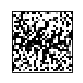

Iteration 155000: loss=9.023892744153272e-12 prediction=4 lr=0.1
Iteration 160000: loss=8.814282637104043e-12 prediction=4 lr=0.1
Iteration 165000: loss=8.608225243733614e-12 prediction=4 lr=0.1
Iteration 170000: loss=8.398615136684384e-12 prediction=4 lr=0.1
Iteration 175000: loss=8.199663170671556e-12 prediction=4 lr=0.1
Iteration 180000: loss=8.007816632016329e-12 prediction=4 lr=0.1
Iteration 185000: loss=7.830180948076304e-12 prediction=4 lr=0.1
Iteration 190000: loss=7.65965069149388e-12 prediction=4 lr=0.1
Iteration 195000: loss=7.492673148590256e-12 prediction=4 lr=0.1
Iteration 200000: loss=7.325695605686633e-12 prediction=4 lr=0.1


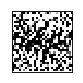

Iteration 205000: loss=7.155165349104209e-12 prediction=4 lr=0.1
Iteration 210000: loss=6.984635092521785e-12 prediction=4 lr=0.1
Iteration 215000: loss=6.817657549618161e-12 prediction=4 lr=0.1
Iteration 220000: loss=6.657785434072139e-12 prediction=4 lr=0.1
Iteration 225000: loss=6.515676886920119e-12 prediction=4 lr=0.1
Iteration 230000: loss=6.394884621840902e-12 prediction=4 lr=0.1
Iteration 235000: loss=6.281197784119286e-12 prediction=4 lr=0.1
Iteration 240000: loss=6.174616373755271e-12 prediction=4 lr=0.1
Iteration 245000: loss=6.071587677070056e-12 prediction=4 lr=0.1
Iteration 250000: loss=5.9685589803848416e-12 prediction=4 lr=0.1


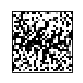

Iteration 255000: loss=5.8690829973784275e-12 prediction=4 lr=0.1
Iteration 260000: loss=5.7625015870144125e-12 prediction=4 lr=0.1
Iteration 265000: loss=5.6488147492927965e-12 prediction=4 lr=0.1
Iteration 270000: loss=5.517364343177178e-12 prediction=4 lr=0.1
Iteration 275000: loss=5.339728659237153e-12 prediction=4 lr=0.1
Iteration 280000: loss=5.112354983793921e-12 prediction=4 lr=0.1
Iteration 285000: loss=4.913403017781093e-12 prediction=4 lr=0.1
Iteration 290000: loss=4.718003765447065e-12 prediction=4 lr=0.1
Iteration 295000: loss=4.54036808150704e-12 prediction=4 lr=0.1
Iteration 300000: loss=4.391154106997419e-12 prediction=4 lr=0.1


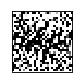

Iteration 305000: loss=4.266809128239402e-12 prediction=4 lr=0.1
Iteration 310000: loss=4.1531222905177856e-12 prediction=4 lr=0.1
Iteration 315000: loss=4.0536463075113716e-12 prediction=4 lr=0.1
Iteration 320000: loss=3.964828465541359e-12 prediction=4 lr=0.1
Iteration 325000: loss=3.8760106235713465e-12 prediction=4 lr=0.1
Iteration 330000: loss=3.787192781601334e-12 prediction=4 lr=0.1
Iteration 335000: loss=3.7054803669889225e-12 prediction=4 lr=0.1
Iteration 340000: loss=3.61666252501891e-12 prediction=4 lr=0.1
Iteration 345000: loss=3.5207392556912964e-12 prediction=4 lr=0.1
Iteration 350000: loss=3.4070524179696804e-12 prediction=4 lr=0.1


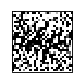

Iteration 355000: loss=3.2791547255328624e-12 prediction=4 lr=0.1
Iteration 360000: loss=3.133493464702042e-12 prediction=4 lr=0.1
Iteration 365000: loss=2.9629632081196178e-12 prediction=4 lr=0.1
Iteration 370000: loss=2.7782220968219917e-12 prediction=4 lr=0.1
Iteration 375000: loss=2.5863755581667647e-12 prediction=4 lr=0.1
Iteration 380000: loss=2.433608869978343e-12 prediction=4 lr=0.1
Iteration 385000: loss=2.305711177541525e-12 prediction=4 lr=0.1
Iteration 390000: loss=2.19912976717751e-12 prediction=4 lr=0.1
Iteration 395000: loss=2.1103119252074976e-12 prediction=4 lr=0.1
Iteration 400000: loss=2.0321522242738865e-12 prediction=4 lr=0.1


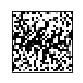

Iteration 405000: loss=1.9610979506978765e-12 prediction=4 lr=0.1
Iteration 410000: loss=1.893596390800667e-12 prediction=4 lr=0.1
Iteration 415000: loss=1.8332002582610585e-12 prediction=4 lr=0.1
Iteration 420000: loss=1.7834622667578515e-12 prediction=4 lr=0.1
Iteration 425000: loss=1.7337242752546445e-12 prediction=4 lr=0.1
Iteration 430000: loss=1.6910917111090384e-12 prediction=4 lr=0.1
Iteration 435000: loss=1.6555645743210334e-12 prediction=4 lr=0.1
Iteration 440000: loss=1.6200374375330284e-12 prediction=4 lr=0.1
Iteration 445000: loss=1.588063014423824e-12 prediction=4 lr=0.1
Iteration 450000: loss=1.55964130499342e-12 prediction=4 lr=0.1


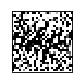

Iteration 455000: loss=1.531219595563016e-12 prediction=4 lr=0.1
Iteration 460000: loss=1.5063505998114124e-12 prediction=4 lr=0.1
Iteration 465000: loss=1.4850343177386094e-12 prediction=4 lr=0.1
Iteration 470000: loss=1.4637180356658064e-12 prediction=4 lr=0.1
Iteration 475000: loss=1.4459544672718039e-12 prediction=4 lr=0.1
Iteration 480000: loss=1.4281908988778014e-12 prediction=4 lr=0.1
Iteration 485000: loss=1.4104273304837989e-12 prediction=4 lr=0.1
Iteration 490000: loss=1.3962164757685969e-12 prediction=4 lr=0.1
Iteration 495000: loss=1.3820056210533949e-12 prediction=4 lr=0.1
Iteration 500000: loss=1.3677947663381929e-12 prediction=4 lr=0.1


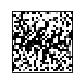

Iteration 505000: loss=1.3535839116229909e-12 prediction=4 lr=0.1
Iteration 510000: loss=1.3393730569077889e-12 prediction=4 lr=0.1
Iteration 515000: loss=1.3287149158713873e-12 prediction=4 lr=0.1
Iteration 520000: loss=1.3145040611561853e-12 prediction=4 lr=0.1
Iteration 525000: loss=1.3038459201197838e-12 prediction=4 lr=0.1
Iteration 530000: loss=1.2931877790833823e-12 prediction=4 lr=0.1
Iteration 535000: loss=1.2825296380469808e-12 prediction=4 lr=0.1
Iteration 540000: loss=1.2754242106893798e-12 prediction=4 lr=0.1
Iteration 545000: loss=1.2647660696529783e-12 prediction=4 lr=0.1
Iteration 550000: loss=1.2541079286165768e-12 prediction=4 lr=0.1


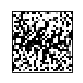

Iteration 555000: loss=1.2470025012589758e-12 prediction=4 lr=0.1
Iteration 560000: loss=1.2398970739013748e-12 prediction=4 lr=0.1
Iteration 565000: loss=1.2292389328649733e-12 prediction=4 lr=0.1
Iteration 570000: loss=1.2221335055073723e-12 prediction=4 lr=0.1
Iteration 575000: loss=1.2150280781497713e-12 prediction=4 lr=0.1
Iteration 580000: loss=1.2079226507921703e-12 prediction=4 lr=0.1
Iteration 585000: loss=1.2008172234345693e-12 prediction=4 lr=0.1
Iteration 590000: loss=1.1937117960769683e-12 prediction=4 lr=0.1
Iteration 595000: loss=1.1866063687193673e-12 prediction=4 lr=0.1
Iteration 600000: loss=1.1795009413617663e-12 prediction=4 lr=0.1


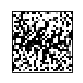

Iteration 605000: loss=1.1723955140041653e-12 prediction=4 lr=0.1
Iteration 610000: loss=1.1688428003253648e-12 prediction=4 lr=0.1
Iteration 615000: loss=1.1617373729677638e-12 prediction=4 lr=0.1
Iteration 620000: loss=1.1546319456101628e-12 prediction=4 lr=0.1
Iteration 625000: loss=1.1510792319313623e-12 prediction=4 lr=0.1
Iteration 630000: loss=1.1439738045737613e-12 prediction=4 lr=0.1
Iteration 635000: loss=1.1404210908949608e-12 prediction=4 lr=0.1
Iteration 640000: loss=1.1333156635373598e-12 prediction=4 lr=0.1
Iteration 645000: loss=1.1297629498585593e-12 prediction=4 lr=0.1
Iteration 650000: loss=1.1226575225009583e-12 prediction=4 lr=0.1


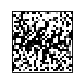

Iteration 655000: loss=1.1191048088221578e-12 prediction=4 lr=0.1
Iteration 660000: loss=1.1155520951433573e-12 prediction=4 lr=0.1
Iteration 665000: loss=1.1084466677857563e-12 prediction=4 lr=0.1
Iteration 670000: loss=1.1048939541069558e-12 prediction=4 lr=0.1
Iteration 675000: loss=1.1013412404281553e-12 prediction=4 lr=0.1
Iteration 680000: loss=1.0942358130705543e-12 prediction=4 lr=0.1
Iteration 685000: loss=1.0906830993917538e-12 prediction=4 lr=0.1
Iteration 690000: loss=1.0871303857129533e-12 prediction=4 lr=0.1
Iteration 695000: loss=1.0800249583553523e-12 prediction=4 lr=0.1
Iteration 700000: loss=1.0764722446765518e-12 prediction=4 lr=0.1


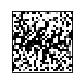

Iteration 705000: loss=1.0729195309977513e-12 prediction=4 lr=0.1
Iteration 710000: loss=1.0693668173189508e-12 prediction=4 lr=0.1
Iteration 715000: loss=1.0622613899613498e-12 prediction=4 lr=0.1
Iteration 720000: loss=1.0587086762825493e-12 prediction=4 lr=0.1
Iteration 725000: loss=1.0551559626037488e-12 prediction=4 lr=0.1
Iteration 730000: loss=1.0516032489249483e-12 prediction=4 lr=0.1
Iteration 735000: loss=1.0480505352461478e-12 prediction=4 lr=0.1
Iteration 740000: loss=1.0444978215673473e-12 prediction=4 lr=0.1
Iteration 745000: loss=1.0373923942097463e-12 prediction=4 lr=0.1
Iteration 750000: loss=1.0338396805309458e-12 prediction=4 lr=0.1


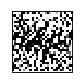

Iteration 755000: loss=1.0302869668521453e-12 prediction=4 lr=0.1
Iteration 760000: loss=1.0267342531733448e-12 prediction=4 lr=0.1
Iteration 765000: loss=1.0231815394945443e-12 prediction=4 lr=0.1
Iteration 770000: loss=1.0196288258157438e-12 prediction=4 lr=0.1
Iteration 775000: loss=1.0125233984581428e-12 prediction=4 lr=0.1
Iteration 780000: loss=1.0089706847793423e-12 prediction=4 lr=0.1
Iteration 785000: loss=1.0054179711005418e-12 prediction=4 lr=0.1
Iteration 790000: loss=1.0018652574217413e-12 prediction=4 lr=0.1
Iteration 795000: loss=9.983125437429408e-13 prediction=4 lr=0.1
Iteration 800000: loss=9.947598300641403e-13 prediction=4 lr=0.1


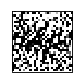

Iteration 805000: loss=9.876544027065393e-13 prediction=4 lr=0.1
Iteration 810000: loss=9.841016890277388e-13 prediction=4 lr=0.1
Iteration 815000: loss=9.805489753489383e-13 prediction=4 lr=0.1
Iteration 820000: loss=9.769962616701378e-13 prediction=4 lr=0.1
Iteration 825000: loss=9.734435479913373e-13 prediction=4 lr=0.1
Iteration 830000: loss=9.698908343125368e-13 prediction=4 lr=0.1
Iteration 835000: loss=9.627854069549358e-13 prediction=4 lr=0.1
Iteration 840000: loss=9.592326932761353e-13 prediction=4 lr=0.1
Iteration 845000: loss=9.556799795973347e-13 prediction=4 lr=0.1
Iteration 850000: loss=9.521272659185342e-13 prediction=4 lr=0.1


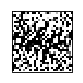

Iteration 855000: loss=9.485745522397337e-13 prediction=4 lr=0.1
Iteration 860000: loss=9.414691248821327e-13 prediction=4 lr=0.1
Iteration 865000: loss=9.379164112033322e-13 prediction=4 lr=0.1
Iteration 870000: loss=9.343636975245317e-13 prediction=4 lr=0.1
Iteration 875000: loss=9.308109838457312e-13 prediction=4 lr=0.1
Iteration 880000: loss=9.272582701669307e-13 prediction=4 lr=0.1
Iteration 885000: loss=9.201528428093297e-13 prediction=4 lr=0.1
Iteration 890000: loss=9.166001291305292e-13 prediction=4 lr=0.1
Iteration 895000: loss=9.130474154517287e-13 prediction=4 lr=0.1
Iteration 900000: loss=9.059419880941277e-13 prediction=4 lr=0.1


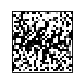

Iteration 905000: loss=9.023892744153272e-13 prediction=4 lr=0.1
Iteration 910000: loss=8.988365607365267e-13 prediction=4 lr=0.1
Iteration 915000: loss=8.952838470577262e-13 prediction=4 lr=0.1
Iteration 920000: loss=8.881784197001252e-13 prediction=4 lr=0.1
Iteration 925000: loss=8.846257060213247e-13 prediction=4 lr=0.1
Iteration 930000: loss=8.775202786637237e-13 prediction=4 lr=0.1
Iteration 935000: loss=8.739675649849232e-13 prediction=4 lr=0.1
Iteration 940000: loss=8.668621376273222e-13 prediction=4 lr=0.1
Iteration 945000: loss=8.633094239485217e-13 prediction=4 lr=0.1
Iteration 950000: loss=8.562039965909207e-13 prediction=4 lr=0.1


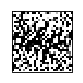

Iteration 955000: loss=8.526512829121202e-13 prediction=4 lr=0.1
Iteration 960000: loss=8.455458555545192e-13 prediction=4 lr=0.1
Iteration 965000: loss=8.384404281969182e-13 prediction=4 lr=0.1
Iteration 970000: loss=8.348877145181177e-13 prediction=4 lr=0.1
Iteration 975000: loss=8.277822871605167e-13 prediction=4 lr=0.1
Iteration 980000: loss=8.206768598029157e-13 prediction=4 lr=0.1
Iteration 985000: loss=8.135714324453147e-13 prediction=4 lr=0.1
Iteration 990000: loss=8.064660050877137e-13 prediction=4 lr=0.1
Iteration 995000: loss=7.993605777301127e-13 prediction=4 lr=0.1
Iteration 1000000: loss=7.922551503725117e-13 prediction=4 lr=0.1


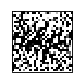

Iteration 1005000: loss=7.851497230149107e-13 prediction=4 lr=0.1
Iteration 1010000: loss=7.780442956573097e-13 prediction=4 lr=0.1
Iteration 1015000: loss=7.709388682997087e-13 prediction=4 lr=0.1
Iteration 1020000: loss=7.638334409421077e-13 prediction=4 lr=0.1
Iteration 1025000: loss=7.602807272633072e-13 prediction=4 lr=0.1
Iteration 1030000: loss=7.531752999057062e-13 prediction=4 lr=0.1
Iteration 1035000: loss=7.460698725481052e-13 prediction=4 lr=0.1
Iteration 1040000: loss=7.425171588693047e-13 prediction=4 lr=0.1
Iteration 1045000: loss=7.354117315117037e-13 prediction=4 lr=0.1
Iteration 1050000: loss=7.318590178329032e-13 prediction=4 lr=0.1


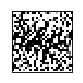

Iteration 1055000: loss=7.283063041541027e-13 prediction=4 lr=0.1
Iteration 1060000: loss=7.212008767965017e-13 prediction=4 lr=0.1
Iteration 1065000: loss=7.176481631177012e-13 prediction=4 lr=0.1
Iteration 1070000: loss=7.140954494389007e-13 prediction=4 lr=0.1
Iteration 1075000: loss=7.105427357601002e-13 prediction=4 lr=0.1
Iteration 1080000: loss=7.069900220812997e-13 prediction=4 lr=0.1
Iteration 1085000: loss=7.034373084024992e-13 prediction=4 lr=0.1
Iteration 1090000: loss=6.998845947236987e-13 prediction=4 lr=0.1
Iteration 1095000: loss=6.963318810448982e-13 prediction=4 lr=0.1
Iteration 1100000: loss=6.927791673660977e-13 prediction=4 lr=0.1


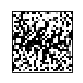

Iteration 1105000: loss=6.892264536872972e-13 prediction=4 lr=0.1
Iteration 1110000: loss=6.856737400084967e-13 prediction=4 lr=0.1
Iteration 1115000: loss=6.821210263296962e-13 prediction=4 lr=0.1
Iteration 1120000: loss=6.785683126508957e-13 prediction=4 lr=0.1
Iteration 1125000: loss=6.750155989720952e-13 prediction=4 lr=0.1
Iteration 1130000: loss=6.714628852932947e-13 prediction=4 lr=0.1
Iteration 1135000: loss=6.679101716144942e-13 prediction=4 lr=0.1
Iteration 1140000: loss=6.679101716144942e-13 prediction=4 lr=0.1
Iteration 1145000: loss=6.643574579356937e-13 prediction=4 lr=0.1
Iteration 1150000: loss=6.608047442568932e-13 prediction=4 lr=0.1


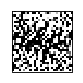

Iteration 1155000: loss=6.572520305780927e-13 prediction=4 lr=0.1
Iteration 1160000: loss=6.536993168992922e-13 prediction=4 lr=0.1
Iteration 1165000: loss=6.536993168992922e-13 prediction=4 lr=0.1
Iteration 1170000: loss=6.501466032204917e-13 prediction=4 lr=0.1
Iteration 1175000: loss=6.465938895416912e-13 prediction=4 lr=0.1
Iteration 1180000: loss=6.430411758628907e-13 prediction=4 lr=0.1
Iteration 1185000: loss=6.430411758628907e-13 prediction=4 lr=0.1
Iteration 1190000: loss=6.394884621840902e-13 prediction=4 lr=0.1
Iteration 1195000: loss=6.359357485052897e-13 prediction=4 lr=0.1
Iteration 1200000: loss=6.359357485052897e-13 prediction=4 lr=0.1


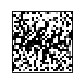

Iteration 1205000: loss=6.323830348264892e-13 prediction=4 lr=0.1
Iteration 1210000: loss=6.288303211476887e-13 prediction=4 lr=0.1
Iteration 1215000: loss=6.288303211476887e-13 prediction=4 lr=0.1
Iteration 1220000: loss=6.252776074688882e-13 prediction=4 lr=0.1
Iteration 1225000: loss=6.252776074688882e-13 prediction=4 lr=0.1
Iteration 1230000: loss=6.217248937900877e-13 prediction=4 lr=0.1
Iteration 1235000: loss=6.181721801112872e-13 prediction=4 lr=0.1
Iteration 1240000: loss=6.181721801112872e-13 prediction=4 lr=0.1
Iteration 1245000: loss=6.146194664324867e-13 prediction=4 lr=0.1
Iteration 1250000: loss=6.146194664324867e-13 prediction=4 lr=0.1


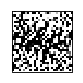

Iteration 1255000: loss=6.110667527536862e-13 prediction=4 lr=0.1
Iteration 1260000: loss=6.110667527536862e-13 prediction=4 lr=0.1
Iteration 1265000: loss=6.075140390748857e-13 prediction=4 lr=0.1
Iteration 1270000: loss=6.075140390748857e-13 prediction=4 lr=0.1
Iteration 1275000: loss=6.039613253960852e-13 prediction=4 lr=0.1
Iteration 1280000: loss=6.039613253960852e-13 prediction=4 lr=0.1
Iteration 1285000: loss=6.004086117172847e-13 prediction=4 lr=0.1
Iteration 1290000: loss=6.004086117172847e-13 prediction=4 lr=0.1
Iteration 1295000: loss=5.968558980384842e-13 prediction=4 lr=0.1
Iteration 1300000: loss=5.968558980384842e-13 prediction=4 lr=0.1


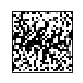

Iteration 1305000: loss=5.968558980384842e-13 prediction=4 lr=0.1
Iteration 1310000: loss=5.933031843596837e-13 prediction=4 lr=0.1
Iteration 1315000: loss=5.933031843596837e-13 prediction=4 lr=0.1
Iteration 1320000: loss=5.897504706808832e-13 prediction=4 lr=0.1
Iteration 1325000: loss=5.897504706808832e-13 prediction=4 lr=0.1
Iteration 1330000: loss=5.861977570020827e-13 prediction=4 lr=0.1
Iteration 1335000: loss=5.861977570020827e-13 prediction=4 lr=0.1
Iteration 1340000: loss=5.861977570020827e-13 prediction=4 lr=0.1
Iteration 1345000: loss=5.826450433232822e-13 prediction=4 lr=0.1
Iteration 1350000: loss=5.826450433232822e-13 prediction=4 lr=0.1


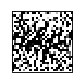

Iteration 1355000: loss=5.826450433232822e-13 prediction=4 lr=0.1
Iteration 1360000: loss=5.790923296444817e-13 prediction=4 lr=0.1
Iteration 1365000: loss=5.790923296444817e-13 prediction=4 lr=0.1
Iteration 1370000: loss=5.790923296444817e-13 prediction=4 lr=0.1
Iteration 1375000: loss=5.755396159656812e-13 prediction=4 lr=0.1
Iteration 1380000: loss=5.755396159656812e-13 prediction=4 lr=0.1
Iteration 1385000: loss=5.755396159656812e-13 prediction=4 lr=0.1
Iteration 1390000: loss=5.719869022868806e-13 prediction=4 lr=0.1
Iteration 1395000: loss=5.719869022868806e-13 prediction=4 lr=0.1
Iteration 1400000: loss=5.719869022868806e-13 prediction=4 lr=0.1


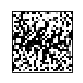

Iteration 1405000: loss=5.719869022868806e-13 prediction=4 lr=0.1
Iteration 1410000: loss=5.719869022868806e-13 prediction=4 lr=0.1
Iteration 1415000: loss=5.684341886080801e-13 prediction=4 lr=0.1
Iteration 1420000: loss=5.684341886080801e-13 prediction=4 lr=0.1
Iteration 1425000: loss=5.684341886080801e-13 prediction=4 lr=0.1
Iteration 1430000: loss=5.684341886080801e-13 prediction=4 lr=0.1
Iteration 1435000: loss=5.684341886080801e-13 prediction=4 lr=0.1
Iteration 1440000: loss=5.648814749292796e-13 prediction=4 lr=0.1
Iteration 1445000: loss=5.648814749292796e-13 prediction=4 lr=0.1
Iteration 1450000: loss=5.648814749292796e-13 prediction=4 lr=0.1


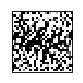

Iteration 1455000: loss=5.648814749292796e-13 prediction=4 lr=0.1
Iteration 1460000: loss=5.613287612504791e-13 prediction=4 lr=0.1
Iteration 1465000: loss=5.613287612504791e-13 prediction=4 lr=0.1
Iteration 1470000: loss=5.613287612504791e-13 prediction=4 lr=0.1
Iteration 1475000: loss=5.613287612504791e-13 prediction=4 lr=0.1
Iteration 1480000: loss=5.613287612504791e-13 prediction=4 lr=0.1
Iteration 1485000: loss=5.613287612504791e-13 prediction=4 lr=0.1
Decreasing LR ..
Iteration 1490000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1495000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1500000: loss=5.577760475716786e-13 prediction=4 lr=0.05


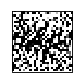

Iteration 1505000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1510000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1515000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1520000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1525000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1530000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1535000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Iteration 1540000: loss=5.577760475716786e-13 prediction=4 lr=0.05
Decreasing LR ..
Iteration 1545000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1550000: loss=5.577760475716786e-13 prediction=4 lr=0.025


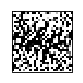

Iteration 1555000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1560000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1565000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1570000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1575000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1580000: loss=5.577760475716786e-13 prediction=4 lr=0.025
Iteration 1585000: loss=5.542233338928781e-13 prediction=4 lr=0.025
Iteration 1590000: loss=5.542233338928781e-13 prediction=4 lr=0.025
Iteration 1595000: loss=5.542233338928781e-13 prediction=4 lr=0.025
Iteration 1600000: loss=5.542233338928781e-13 prediction=4 lr=0.025


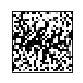

Iteration 1605000: loss=5.542233338928781e-13 prediction=4 lr=0.025
Iteration 1610000: loss=5.542233338928781e-13 prediction=4 lr=0.025
Decreasing LR ..
Iteration 1615000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1620000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1625000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1630000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1635000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1640000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1645000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1650000: loss=5.542233338928781e-13 prediction=4 lr=0.0125


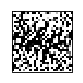

Iteration 1655000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1660000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Iteration 1665000: loss=5.542233338928781e-13 prediction=4 lr=0.0125
Decreasing LR ..
Iteration 1670000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1675000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1680000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1685000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1690000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1695000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1700000: loss=5.542233338928781e-13 prediction=4 lr=0.00625


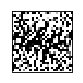

Iteration 1705000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1710000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1715000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Iteration 1720000: loss=5.542233338928781e-13 prediction=4 lr=0.00625
Decreasing LR ..
Iteration 1725000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1730000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1735000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1740000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1745000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1750000: loss=5.542233338928781e-13 prediction=4 lr=0.003125


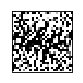

Iteration 1755000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1760000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1765000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1770000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Iteration 1775000: loss=5.542233338928781e-13 prediction=4 lr=0.003125
Decreasing LR ..
Iteration 1780000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1785000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1790000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1795000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1800000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625


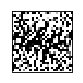

Iteration 1805000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1810000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1815000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1820000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1825000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Iteration 1830000: loss=5.542233338928781e-13 prediction=4 lr=0.0015625
Decreasing LR ..
Iteration 1835000: loss=5.542233338928781e-13 prediction=4 lr=0.00078125


KeyboardInterrupt: 

In [23]:
new_image_randn, loss_stats = generate_image(img, 4)

Изображение цифры "4" достаточно легко распознать, несмотря на шум